Dataset information:
<xarray.Dataset> Size: 124MB
Dimensions:                (time: 1, bnds: 2, lon: 1440, lat: 600)
Coordinates:
  * time                   (time) datetime64[ns] 8B 2000-01-01
  * lon                    (lon) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * lat                    (lat) float32 2kB -59.88 -59.62 ... 89.62 89.88
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] 16B ...
    Swnet_tavg             (time, lat, lon) float32 3MB ...
    Lwnet_tavg             (time, lat, lon) float32 3MB ...
    Qle_tavg               (time, lat, lon) float32 3MB ...
    Qh_tavg                (time, lat, lon) float32 3MB ...
    Qg_tavg                (time, lat, lon) float32 3MB ...
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 3MB ...
    Tair_f_inst            (time, lat, lon) float32 3MB ...
    Qair_f_inst            (time, lat, lon) float32 3MB ...
    Psurf_f_inst     

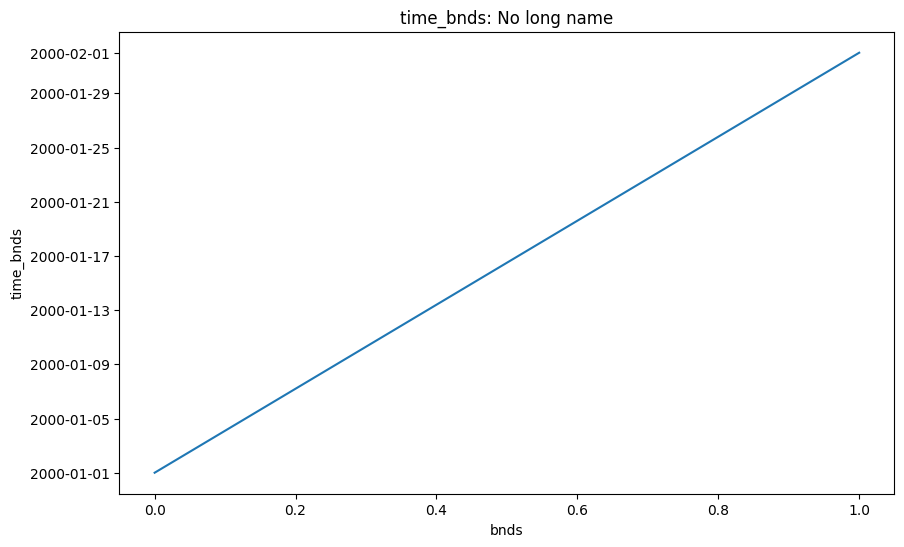

In [7]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

# Open the NetCDF file using xarray
ds = xr.open_dataset('../../Data/data_GLDAS/GLDAS_NOAH025_M.A200001.021.nc4')


# Print basic information about the dataset
print("Dataset information:")
print(ds)

# Print the dimensions
print("\nDimensions:")
print(ds.dims)

# Print the variables
print("\nVariables:")
for var_name, var in ds.variables.items():
    print(f"{var_name}: {var.attrs.get('long_name', 'No long name')} - {var.dims} - {var.dtype}")

# Print global attributes
print("\nGlobal attributes:")
for attr_name, attr_value in ds.attrs.items():
    print(f"{attr_name}: {attr_value}")

# Get a sample variable to visualize (first variable with >= 2 dimensions)
sample_var = None
for var_name, var in ds.variables.items():
    if len(var.dims) >= 2:
        sample_var = var_name
        break

if sample_var:
    plt.figure(figsize=(10, 6))
    ds[sample_var].isel(time=0).plot()
    plt.title(f"{sample_var}: {ds[sample_var].attrs.get('long_name', 'No long name')}")
    plt.show()

Using soil moisture variable: RootMoist_inst


<Figure size 1200x800 with 0 Axes>

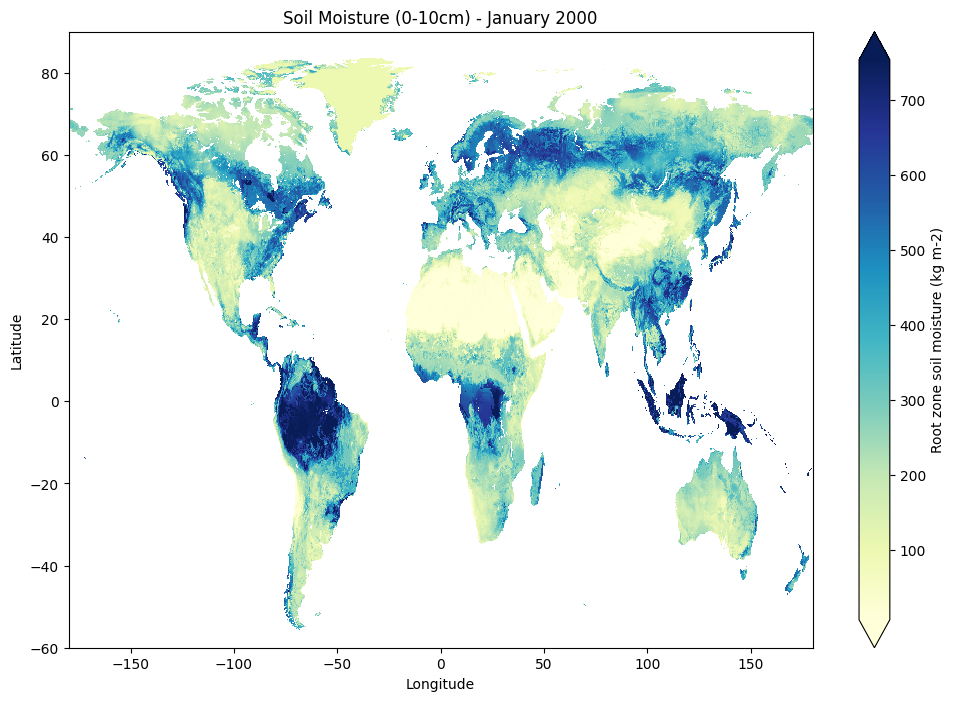

In [8]:
# Check if soil moisture variable for 0-10cm layer exists
sm_vars = [var for var in ds.variables if "moist" in var.lower() and "0_10" in var.lower() or "0-10" in var.lower()]

if sm_vars:
    sm_var = sm_vars[0]
    print(f"Found soil moisture variable: {sm_var}")
else:
    # If not explicitly named for 0-10cm, look for soil moisture variables with layer information
    sm_vars = [var for var in ds.variables if "moist" in var.lower() or "sm" == var.lower()]
    sm_var = sm_vars[0] if sm_vars else None
    print(f"Using soil moisture variable: {sm_var}")

if sm_var:
    plt.figure(figsize=(12, 8))
    # Plot the soil moisture map for the first time step
    sm_plot = ds[sm_var].isel(time=0).plot(
        cmap='YlGnBu', 
        robust=True,
        figsize=(12, 8),
        cbar_kwargs={'label': f'{ds[sm_var].attrs.get("long_name", sm_var)} ({ds[sm_var].attrs.get("units", "unknown units")})'}
    )
    plt.title(f'Soil Moisture (0-10cm) - January 2000')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("No soil moisture variable found in the dataset. Available variables are:")
    for var_name in ds.variables:
        print(f"- {var_name}: {ds[var_name].attrs.get('long_name', 'No long name')}")


In [9]:
import xarray as xr
import pandas as pd
from pathlib import Path
import os 
import warnings # To suppress potential warnings during concatenation if needed


data_folder = Path('../../Data/data_GLDAS') # Using relative path 

# Specify the file pattern to search for
file_pattern = '*.nc4' 

# Define approximate geographic bounds for Canada
lat_min, lat_max = 41.0, 83.0
lon_min, lon_max = -141.0, -52.0

# --- Define EXACT soil moisture variables to extract ---
TARGET_SM_VARIABLES = [
    'SoilMoi0_10cm_inst', 
    'SoilMoi10_40cm_inst', 
    'SoilMoi40_100cm_inst', 
    'SoilMoi100_200cm_inst'
]

# --- Main Script ---
all_dataframes = [] # List to hold DataFrames from each file

print(f"Searching for files matching '{file_pattern}' in folder: {data_folder}")
print(f"Target variables: {TARGET_SM_VARIABLES}")

# Check if the folder exists
if not data_folder.is_dir():
    print(f"Error: Folder not found at {data_folder}")
    exit()

# --- Create the Canada mask ---
# Need to load one file just to get the coordinates for the mask
try:
    # Find the first file matching the pattern to create the mask
    first_file = next(data_folder.glob(file_pattern), None)
    if first_file is None:
        print(f"Error: No files matching '{file_pattern}' found in {data_folder} to create mask.")
        exit()
        
    print(f"Using file '{first_file.name}' to create coordinate mask.")
    with xr.open_dataset(first_file) as ds_example:
        # Ensure lat/lon coordinates exist
        if 'lat' not in ds_example.coords or 'lon' not in ds_example.coords:
             print(f"Error: 'lat' or 'lon' coordinates not found in example file {first_file.name}")
             exit()
        # Create the boolean mask based on coordinates
        canada_mask = (
            (ds_example['lat'] >= lat_min) & (ds_example['lat'] <= lat_max) &
            (ds_example['lon'] >= lon_min) & (ds_example['lon'] <= lon_max)
        )
        # Check if the mask is empty (e.g., bounds are outside data range)
        if not canada_mask.any():
             print("Warning: The defined Canada bounds result in an empty mask for the example file's coordinates.")
             # Decide whether to exit or continue (continuing might result in no data)
             # exit() 
             
except Exception as e:
    print(f"Error creating Canada mask from file {first_file.name}: {e}")
    exit()

# --- Iterate through files and process data ---
# limit_files = 20 # Set a limit for testing, set to None for processing all files
limit_files = None # Process all files

file_counter = 0
processed_files_count = 0 # Counts files from which data was actually extracted

for filepath in data_folder.glob(file_pattern):
    # Apply the overall file limit if set
    if limit_files is not None and file_counter >= limit_files:
        print(f"\nStopping file iteration after attempting {limit_files} files (limit is set).")
        break
        
    file_counter += 1
    print(f"\nProcessing file {file_counter}: {filepath.name}")
    
   

    try:
        # Open the dataset using a 'with' statement for automatic closing
        with xr.open_dataset(filepath) as ds:
            
            # Check coordinate consistency before applying mask 
            if not ds.coords['lat'].equals(ds_example.coords['lat']) or \
               not ds.coords['lon'].equals(ds_example.coords['lon']):
                print(f"Warning: Coordinates in {filepath.name} differ from the mask's base file. Skipping mask application or re-creating mask might be needed.")
                
            
            # Apply the Canada mask
            ds_masked = ds.where(canada_mask, drop=False) 
            
            # --- Check which of the TARGET variables are present in this file ---
            present_sm_vars = [var for var in TARGET_SM_VARIABLES if var in ds_masked.variables]
            
            if present_sm_vars:
                print(f"  Found present target variables: {present_sm_vars}")
                # Select only the soil moisture variables that are present
                ds_sm_selected = ds_masked[present_sm_vars]

                # Convert the selected DataArrays to a single Pandas DataFrame
                df_temp = ds_sm_selected.to_dataframe() 

                # Reset index to make time, lat, lon regular columns
                df_temp.reset_index(inplace=True)

                # Drop rows where ALL the *present* soil moisture variables are NaN.
                # This effectively removes grid cells outside the Canada mask.
                df_temp.dropna(subset=present_sm_vars, how='all', inplace=True)

                if not df_temp.empty:
                    # Append the DataFrame (containing only Canadian data) to our list
                    all_dataframes.append(df_temp)
                    print(f"  Successfully extracted {len(present_sm_vars)} SM variables for Canada region.")
                    processed_files_count += 1 # Increment count of successfully processed files
                else:
                    print("  Dataframe is empty after masking and NaN drop (no valid SM data in Canada region for this file).")

            else:
                # This case means *none* of the TARGET_SM_VARIABLES were found in this file
                print(f"Warning: None of the target soil moisture variables ({TARGET_SM_VARIABLES}) found in {filepath.name}. Skipping file.")


    except Exception as e:
        print(f"Error processing file {filepath.name}: {e}")
        # Decide if you want to stop or continue with other files
        # continue # Uncomment to skip problematic files and continue


# --- Concatenate and Finalize ---
if all_dataframes:
    print(f"\nConcatenating data from {processed_files_count} successfully processed files...")
    # Suppress warnings about potentially different dtypes if columns match but had NaNs differently
    with warnings.catch_warnings():
         warnings.simplefilter("ignore", category=FutureWarning) # Catches some concat warnings
         # Concatenation naturally handles missing columns by filling with NaN
         final_df = pd.concat(all_dataframes, ignore_index=True)

    print("\nFinal DataFrame Info:")
    final_df.info(verbose=True, show_counts=True) # More detailed info

    print("\nFinal DataFrame Head:")
    print(final_df.head())

    print("\nFinal DataFrame Tail:")
    print(final_df.tail())

    # --- Save the final DataFrame as CSV ---
    # Ensure the output folder exists if saving
    output_folder = Path('../../Data/data_GLDAS') # Save in a subfolder named 'output'
    output_folder.mkdir(parents=True, exist_ok=True) 
    
    output_filename_csv = output_folder / "compiled_canada_soil_moisture.csv"
    print(f"\nSaving compiled data to {output_filename_csv}...")
    # Save to CSV format, do not include the pandas index column
    final_df.to_csv(output_filename_csv, index=False) 
    print("Save complete.")


else:
    print(f"\nNo data was extracted after attempting {file_counter} files.")
    print("Please check:")
    print(f"  - If the target variables ({TARGET_SM_VARIABLES}) exist in the NetCDF files.")
    print("  - The folder path and file pattern.")
    print("  - If the Canada geographic bounds overlap with the data coordinates.")
    print("  - If any errors occurred during file processing.")

print("\nScript finished.")

Searching for files matching '*.nc4' in folder: ../../Data/data_GLDAS
Target variables: ['SoilMoi0_10cm_inst', 'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilMoi100_200cm_inst']
Using file 'GLDAS_NOAH025_M.A201902.021.nc4' to create coordinate mask.

Processing file 1: GLDAS_NOAH025_M.A201902.021.nc4
  Found present target variables: ['SoilMoi0_10cm_inst', 'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilMoi100_200cm_inst']
  Successfully extracted 4 SM variables for Canada region.

Processing file 2: GLDAS_NOAH025_M.A201301.021.nc4
  Found present target variables: ['SoilMoi0_10cm_inst', 'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilMoi100_200cm_inst']
  Successfully extracted 4 SM variables for Canada region.

Processing file 3: GLDAS_NOAH025_M.A200803.021.nc4
  Found present target variables: ['SoilMoi0_10cm_inst', 'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilMoi100_200cm_inst']
  Successfully extracted 4 SM variables for Canada region.

Processing file 4: GLDAS

In [10]:
# order the csv with the time column 
df_to_sort = pd.read_csv(output_filename_csv)
# Convert the 'time' column to datetime format
df_to_sort['time'] = pd.to_datetime(df_to_sort['time'])
# Sort the DataFrame by 'time' column
df_to_sort.sort_values(by='time', inplace=True)
# Save the ordered DataFrame back to CSV
df_to_sort.to_csv(output_filename_csv, index=False)
print(f"Sorted data saved to {output_filename_csv}.")


Sorted data saved to ../../Data/data_GLDAS/compiled_canada_soil_moisture.csv.


MovieWriter imagemagick unavailable; using Pillow instead.


Animation saved as ../../output/soil_moisture_animation.gif.


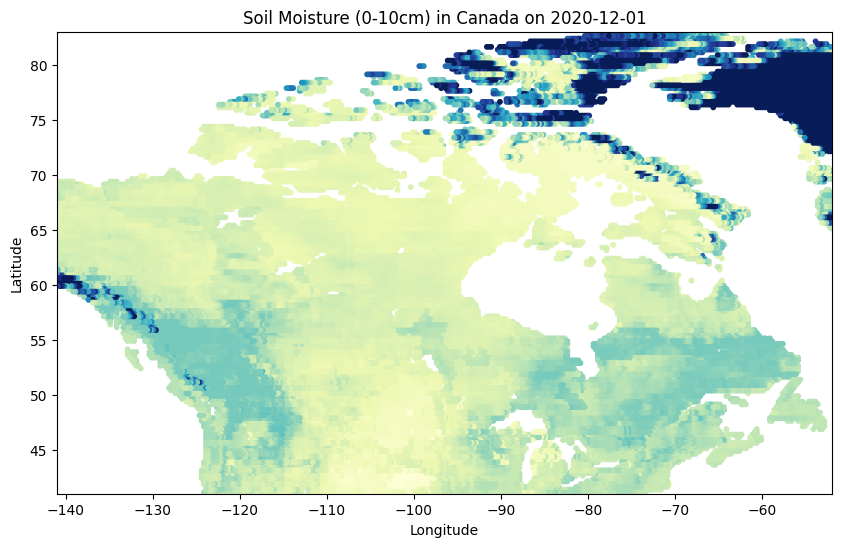

: 

In [ ]:
# plot the soil moisture for the years 2015-2020 as a gif
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np

# Load the compiled data
compiled_data = pd.read_csv(output_filename_csv)

# Convert the 'time' column to datetime
compiled_data['time'] = pd.to_datetime(compiled_data['time'])
# Filter the data for the years 2015-2020
mask = (compiled_data['time'] >= '2015-01-01') & (compiled_data['time'] <= '2020-12-31')
filtered_data = compiled_data[mask]
# Check if the filtered data is empty
if filtered_data.empty:
    print("No data available for the specified date range (2015-2020).")

# #create the matplotlib code which plots the soil moisture 10 values
fig = plt.figure(figsize=(10, 6))
# Set the initial plot
# Create a scatter plot for the first time step
def init():
    plt.scatter([], [])
    plt.xlim(-141, -52)
    plt.ylim(41, 83)
    plt.title('Soil Moisture (0-10cm) in Canada (2015-2020)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    return fig,
# Update function for animation
def update(frame):
    plt.clf()  # Clear the previous plot
    # Filter data for the current time step
    current_time = filtered_data['time'].unique()[frame]
    current_data = filtered_data[filtered_data['time'] == current_time]
    
    # Create a scatter plot for the current time step
    plt.scatter(current_data['lon'], current_data['lat'], c=current_data['SoilMoi0_10cm_inst'], cmap='YlGnBu', s=10)
    plt.xlim(-141, -52)
    plt.ylim(41, 83)
    plt.title(f'Soil Moisture (0-10cm) in Canada on {current_time.date()}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    return fig,
# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(filtered_data['time'].unique()), init_func=init, blit=True)
# Save the animation as a GIF
output_filename_gif = "../../output/soil_moisture_animation.gif"
ani.save(output_filename_gif, writer='imagemagick', fps=7)
print(f"Animation saved as {output_filename_gif}.")
